Behavioral Cloning from Observation (BCO) [paper link](https://arxiv.org/pdf/1805.01954v2.pdf)

In [1]:
import torchvision
import numpy as np 
import gym
import torch
import torch.nn as nn
import torch.functional as F
from matplotlib import pyplot as plt
from IPython import display
from matplotlib import style
plt.style.use("ggplot")

In [27]:
# init environment
env_name = "Pendulum-v0"
env = gym.make(env_name)
action_space_size = env.action_space.shape[0]
state_space_size  = env.observation_space.shape[0]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("state_space_size", state_space_size)
print("action_space_size", action_space_size)
print("device", device)
n=2

state_space_size 3
action_space_size 1
device cpu


&emsp;&emsp;加载专家数据，这里加载的专家数据中只有观测数据。

In [3]:
# Load Expert data (States only for BCO)
expert_states  = torch.tensor(np.load("states_expert_Pendulum.npy"), dtype=torch.float)
print("expert_states", expert_states.shape)

expert_states torch.Size([500, 200, 3])


In [4]:
# Load new data (states and actions for BCO)
states_new_agent  =  torch.tensor(np.load ("states_Pendulum_exploration.npy")[:1000], dtype= torch.float)
actions_new_agent =  torch.tensor(np.load ("actions_Pendulum_exploration.npy")[:1000], dtype= torch.float)
print("states_new_agent",states_new_agent.shape)
print("actions_new_agent",actions_new_agent.shape)

states_new_agent torch.Size([1000, 200, 3])
actions_new_agent torch.Size([1000, 200, 1])


In [5]:
def to_input (states, actions=None,  n=2, compare=1):
    '''
    Data preperpation and filtering 
    Inputs:
    states: expert states as tensor
    actions: actions states as tensor
    n: window size (how many states needed to predict the next action)
    compare: for filtering data 
    return:
    output_states: filtered states as tensor 
    output_actions: filtered actions as tensor if actions != None
    '''
    count=0
    index= []

    if type(actions) != torch.Tensor:
        ep, t, state_size = states.shape
    else:
        ep, t, state_size = states.shape
        _, _, action_size = actions.shape

    
    if type(actions) != torch.Tensor:
        output_states = torch.zeros((ep*(t-n+1) , state_size*n), dtype = torch.float)
    else:
        output_states = torch.zeros((ep*(t-n+1) , state_size*n), dtype = torch.float)
        output_actions = torch.zeros((ep*(t-n+1) , action_size), dtype = torch.float)
        
    
    for i in range (ep):
        for j in range (t-n+1):
            if (states[i, j] == -compare*torch.ones(state_size)).all() or (states[i, j+1] == -compare*torch.ones(state_size)).all():
                index.append([i,j])
            else:
                output_states[count] = states[i, j:j+n].view(-1)

            if type(actions) != torch.Tensor:
                count+=1
                # do nothing
            else:
                output_actions[count] = actions[i,j]
                count+=1
   
    if type(actions) != torch.Tensor:
        output_states= output_states[:count]
        return output_states
    else:
        output_states  = output_states[:count]
        output_actions = output_actions[:count]
        return output_states, output_actions

In [6]:
# selecting number expert trajectories from expert data
# number_expert_trajectories = 50
# a= np.random.randint(expert_states.shape[0] - number_expert_trajectories)
# print(a)
# expert_state, expert_action = to_input (expert_states[a : a+number_expert_trajectories], expert_actions[a : a+number_expert_trajectories], n=n,  compare=5)
# print("expert_state", expert_state.shape)

&emsp;&emsp;训练状态转移：

In [7]:
def train_transition (training_set, model, n=2,   batch_size = 256, n_epoch = 50):
    '''
    train transition model, given pair of states return action (s0,s1 ---> a0 if n=2)
    Input:
    training_set: 
    model: transition model want to train
    n: window size (how many states needed to predict the next action)
    batch_size: batch size
    n_epoch: number of epoches
    return:
    model: trained transition model
    '''
    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 
    loss_list = []
    for itr in range(n_epoch):
        total_loss = 0
        b=0
        for batch in range (0,training_set.shape[0], batch_size):
            data   = training_set  [batch : batch+batch_size , :n*state_space_size]
            y      = training_set [batch : batch+batch_size, n*state_space_size:]
            y_pred = model(data)
            loss   = criterion(y_pred, y)
            total_loss += loss.item() 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            b += 1
        print("[EPOCH]: %i, [LOSS]: %.6f" % (itr+1, total_loss/b))
        display.clear_output(wait=True)
        loss_list.append(total_loss / training_set.shape[0])
    return model

In [8]:
def train_BC (training_set , policy,   batch_size = 256, n_epoch = 50):
    '''
    train Behavioral Cloning model, given pair of states return action (s0,s1 ---> a0 if n=2)
    Input:
    training_set: 
    policy: Behavioral Cloning model want to train
    n: window size (how many states needed to predict the next action)
    batch_size: batch size
    n_epoch: number of epoches
    return:
    policy: trained Behavioral Cloning model
    '''
    
    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(policy.parameters(), lr=0.001) 
    loss_list = []
    for itr in range(n_epoch):
        total_loss = 0
        b=0
        for batch in range (0,training_set.shape[0], batch_size):
            data   = training_set  [batch : batch+batch_size , :state_space_size]
            y      = training_set [batch : batch+batch_size, state_space_size:]
            y_pred = policy(data)
            loss   = criterion(y_pred, y)
            total_loss += loss.item() 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            b += 1
        print("[EPOCH]: %i, [LOSS]: %.6f" % (itr+1, total_loss/b))
        display.clear_output(wait=True)
        loss_list.append(total_loss / training_set.shape[0])
    return policy

## Behavioral Cloning from Observation BCO and BCO($\alpha$)

In [9]:
states_new_agent, actions_new_agent = to_input(states_new_agent, actions_new_agent, n=n, compare=5 )
new_agent_data = torch.cat((states_new_agent , actions_new_agent), 1)
new_agent_data = new_agent_data.detach().numpy()
np.random.shuffle(new_agent_data)
new_agent_data = torch.tensor(new_agent_data[:])
print("new_agent_data", new_agent_data.shape)
n_samples = int(new_agent_data.shape[0]*0.7)
training_set = new_agent_data[:n_samples]
testing_set = new_agent_data[n_samples:]
print("training_set", training_set.shape)
print("testing_set", testing_set.shape)

new_agent_data torch.Size([199000, 7])
training_set torch.Size([139300, 7])
testing_set torch.Size([59700, 7])


In [10]:
state_trainsition_model = nn.Sequential(
    
    nn.Linear(n*state_space_size, 20),
    nn.ReLU(),
    
    nn.Linear(20, 40),
    nn.ReLU(),
    
    nn.Linear(40, 10),
    nn.ReLU(),
    
    nn.Linear(10, action_space_size)
)

criterion = nn.L1Loss()

In [11]:
n_epoch = 500
batch_size = 128
learning_rate = 0.001
optimizer = torch.optim.Adam(state_trainsition_model.parameters(), lr = learning_rate) 

loss_list = []
test_list = []

for itr in range (n_epoch):
    total_loss = 0
    b = 0
    for batch in range (0,training_set.shape[0], batch_size):
        x      = training_set  [batch : batch+batch_size , :n*state_space_size]
        y      = training_set  [batch : batch+batch_size , n*state_space_size:]
        y_pred = state_trainsition_model(x)
        loss   = criterion(y_pred, y)
        total_loss += loss.item() 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        b += 1
    print("[EPOCH]: %i, [LOSS]: %.6f" % (itr+1, total_loss / b))
    display.clear_output(wait=True)
    loss_list.append(total_loss / b)
    
    test_list.append(criterion(state_trainsition_model(testing_set[:, :n*state_space_size]), testing_set[:, n*state_space_size: ]).item())

[EPOCH]: 500, [LOSS]: 0.012064


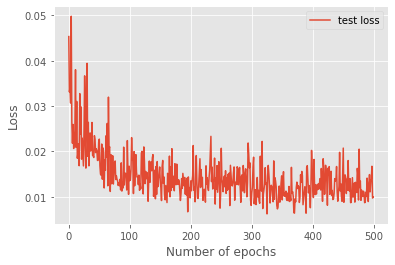

In [12]:
plt.plot(test_list, label="test loss")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.legend()

In [13]:
p = 42511  # select any point to test the model
print( state_trainsition_model(testing_set[p, :n*state_space_size]))
print(testing_set[p, n*state_space_size:])
criterion(state_trainsition_model(testing_set[p, :n*state_space_size]), testing_set[p, n*state_space_size:] ).item()

tensor([1.8529], grad_fn=<AddBackward0>)
tensor([1.8506])


0.002256631851196289

Load pre-trained Transition Model and predict infered expert actions from expert states only

In [14]:
expert_states = to_input(expert_states,  actions=None, n=n, compare=5)
expert_states = expert_states.detach().numpy()
np.random.shuffle(expert_states)
expert_states = torch.tensor(expert_states)

# state_trainsition_model = torch.load("pendulum_transition_model_from_exploration_states_l1_n=2")
infered_expert_actions  = state_trainsition_model(expert_states).detach().numpy()
infered_expert_actions = torch.tensor(infered_expert_actions, requires_grad=False)
infered_expert_actions = torch.clamp(infered_expert_actions, -2, 2)

In [15]:
new_data = torch.cat((expert_states[:, :state_space_size], infered_expert_actions),1)

n_samples = int(new_data.shape[0]*0.7)
training_set = new_data[:n_samples]
testing_set = new_data[n_samples:]
print("training_set", training_set.shape)
print("testing_set", testing_set.shape)

training_set torch.Size([69650, 4])
testing_set torch.Size([29850, 4])


In [16]:
# Network arch, loss function and optimizer

bco_pendulum = nn.Sequential(
    nn.Linear(state_space_size,40),
    nn.ReLU(),
    
    nn.Linear(40,60),
    nn.ReLU(),
    
    nn.Linear(60,20),
    nn.ReLU(),
    
    nn.Linear(20,action_space_size),
)

criterion = nn.L1Loss()

In [17]:
# Train BCO model 
loss_list = []
test_loss = []

batch_size = 256
n_epoch = 500

learning_rate = 0.001
optimizer = torch.optim.Adam(bco_pendulum.parameters(), lr = learning_rate) 

for itr in range(n_epoch):
    total_loss = 0
    b=0
    for batch in range (0,training_set.shape[0], batch_size):
        data   = training_set  [batch : batch+batch_size , :state_space_size]
        y      = training_set  [batch : batch+batch_size , state_space_size:]
        y_pred = bco_pendulum(data)
        loss   = criterion(y_pred, y)
        total_loss += loss.item() 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        b += 1
    print("[EPOCH]: %i, [LOSS]: %.6f" % (itr+1, total_loss / b))
    display.clear_output(wait=True)
    loss_list.append(total_loss / b)
    x = testing_set[:, :state_space_size]
    y = testing_set[:,state_space_size:]
    y_pred = bco_pendulum(x)
    test_loss.append(criterion(y_pred, y).item())

[EPOCH]: 500, [LOSS]: 0.758694


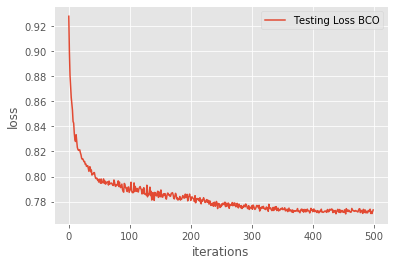

In [18]:
# plot test loss for BCO
# torch.save(bco_pendulum, "bco_pendulum_n=2") #uncomment to save model
plt.plot(test_loss, label="Testing Loss BCO")
plt.xlabel("iterations")
plt.ylabel("loss")
plt.legend()
plt.show()

In [19]:
p = 112 # select any point to test the model
print( bco_pendulum(testing_set[p, :state_space_size]))
print(testing_set[p, state_space_size:])
criterion(bco_pendulum(testing_set[p, :state_space_size]), testing_set[p, state_space_size:] ).item()

tensor([-0.2116], grad_fn=<AddBackward0>)
tensor([1.9960])


2.207597255706787

Train BCO($\alpha$) in Pendulum with interacting with environmet

In [20]:
################################## parameters ##################################
n=2 # window size
n_iterations = 100 # max number of interacting with environment
n_ep = 1000 # number of epoches
max_steps = 200 # max timesteps per epoch
gamma = 1.0 # discount factor
seeds = np.zeros(n_iterations) # random seeds
target_reward = -300 # stop training when reward > targit_reward
################################## parameters ##################################


seed_reward_mean = []
seed_reward  = []

for itr in range (n_iterations):
   ################################## interact with env ##################################
    G= []
    G_mean = []
    env.seed(int(seeds[itr]))
    torch.manual_seed(int(seeds[itr]))
    torch.cuda.manual_seed_all(int(seeds[itr]))

    states_from_env  = -5*np.ones((n_ep, max_steps, state_space_size)) # states in
    actions_from_env = -5*np.ones((n_ep, max_steps, action_space_size))
    
    for ep in range (n_ep):
        state = env.reset()
        rewards = []
        R=0
        for t in range (max_steps):
            action = bco_pendulum(torch.tensor(state, dtype=torch.float))
            
            action = np.clip(action.detach().numpy(), -2,2) # clip action to be between (-1, 1)
            
            states_from_env[ep,t]  = state
            actions_from_env[ep,t] = action
            next_state , r, done, _   = env.step(action)
            rewards.append(r)
            state = next_state
            if done:
                break
        R = sum([rewards[i]*gamma**i for i in range (len(rewards))])
        G.append(R)
        G_mean.append(np.mean(G))
        
        
        if ep % 1 ==0:
            print("ep = {} , Mean Reward = {:.6f}".format(ep, R))
        display.clear_output(wait=True)
    seed_reward.append(G)
    seed_reward_mean.append(G_mean)
    
    print("Itr = {} overall reward  = {:.6f} ".format(itr, np.mean(seed_reward_mean[-1])))
    print("Interacting with environment finished")

        
    if np.mean(seed_reward_mean[-1]) > target_reward:
        torch.save(bco_pendulum, "bco_pendulum={}_BCO({})_best_{}_expert_states".format(n,itr,expert_states.shape[0]))        
        break
    ################################ prepare collected states and actions ##################################
    
    states_from_env = torch.tensor(states_from_env, dtype=torch.float)
    actions_from_env = torch.tensor(actions_from_env, dtype=torch.float)
    states_from_env, actions_from_env = to_input(states_from_env, actions_from_env , n=n, compare=5)
    data_env = torch.cat((states_from_env, actions_from_env), 1).detach().numpy()
    np.random.shuffle(data_env)
    data_env = torch.tensor(data_env)
    print("data_env", data_env.shape)
    
    #################################  Update Transition Model and return infeered expert actions ##################################
    
    state_trainsition_model = train_transition( data_env ,  state_trainsition_model,  n=n )
    infered_expert_actions  = state_trainsition_model( torch.tensor(expert_states) )
    infered_expert_actions = torch.tensor( infered_expert_actions, requires_grad=False )
    print("Updated Transition Model and returned infeered expert actions")
    
    ################################# Update BC model ##################################
    
    expert_data = torch.cat((expert_states, infered_expert_actions),1)
    bco_pendulum = train_BC(expert_data, bco_pendulum, n_epoch =100)
    print(" Updated BC model itra= {}".format(itr))
    print("finished")
    
print(" Updated BC model itra= {}".format(itr))

Itr = 0 overall reward  = -206.919030 
Interacting with environment finished
 Updated BC model itra= 0


Test BCO($\alpha$) in Pendulum environment with 5 random seeds

In [21]:
x = itr
n_iterations = 5
n_ep = 1000
max_steps = 200
gamma = 1.0 # discount factor
seeds = [684, 559, 629, 192, 835]


seed_reward_mean = []
seed_reward  = []
for itr in range (n_iterations):
   ################################## interact with env ##################################
    G= []
    G_mean = []
    env.seed(int(seeds[itr]))
    torch.manual_seed(int(seeds[itr]))
    torch.cuda.manual_seed_all(int(seeds[itr]))

    for ep in range (n_ep):
        state = env.reset()
        rewards = []
        R=0
        for t in range (max_steps):      
            action = bco_pendulum(torch.tensor(state, dtype=torch.float))
            action = np.clip(action.detach().numpy(), -2,2)
            next_state , r, done, _   = env.step(action)
            rewards.append(r)
            state = next_state
            if done:
                break
        R = sum([rewards[i]*gamma**i for i in range (len(rewards))])
        G.append(R)
        G_mean.append(np.mean(G))
        if ep % 1 ==0:
            print("ep = {} , Mean Reward = {:.6f}".format(ep, R))
        display.clear_output(wait=True)
    seed_reward.append(G)
    seed_reward_mean.append(G_mean)
    print("Itr = {} overall reward  = {:.6f} ".format(itr, np.mean(seed_reward_mean[-1])))
    print("Interacting with environment finished")
# np.save("reward_mean_pendulum_n={}_bco({})_expert_states={}".format(n, x , expert_states.shape[0]), seed_reward_mean) #uncomment to save the reward over 5 random seeds

Itr = 4 overall reward  = -197.658275 
Interacting with environment finished


BCO

In [22]:
seed_reward_mean_bco = np.array(seed_reward_mean)
mean_bco  = np.mean(seed_reward_mean_bco,axis=0)
std_bco  = np.std(seed_reward_mean_bco,axis=0)

Expert

In [23]:
expert  = np.load("reward_mean_pendulum_expert.npy")
mean_expert= np.mean(expert,axis=0)
std_expert = np.std(expert,axis=0)

Random

In [24]:
random_mean  = np.load("reward_mean_pendulum_random.npy")
mean_random= np.mean(random_mean,axis=0)
std_random  = np.std(random_mean,axis=0)

In [25]:
# Scaled performance
def scaled (x, min_value, max_value):
    return (x - min_value) / (max_value - min_value)

bco_score = scaled( mean_bco[-1]  , mean_random[-1] , mean_expert[-1] )

Compare BCO VS Expert VS Random

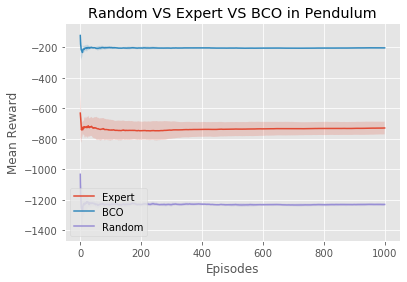

In [26]:
x = np.arange(1000)

plt.plot(x, mean_expert, "-", label="Expert")
plt.fill_between(x, mean_expert+std_expert, mean_expert-std_expert, alpha=0.2)

plt.plot(x, mean_bco, "-", label="BCO")
plt.fill_between(x, mean_bco + std_bco, mean_bco - std_bco, alpha=0.2)

plt.plot(x, mean_random, "-", label="Random")
plt.fill_between(x, mean_random+std_random, mean_random-std_random, alpha=0.2)

plt.xlabel("Episodes")
plt.ylabel("Mean Reward")
plt.title("Random VS Expert VS BCO in Pendulum")
plt.legend()